# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [3]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 4.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 1.4 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [4]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [5]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-05-25 06:16:39--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.48
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  43.5MB/s    in 27s     

2023-05-25 06:17:14 (40.4 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [8]:
#upload data to S3
session=sagemaker.Session()
bucket=session.default_bucket()
prefix="third_project/dog_breed_images"
data = session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print(f"Data Path: {data}")

Data Path: s3://sagemaker-us-east-1-372206764755/third_project/dog_breed_images


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [3]:
import sagemaker
import boto3
from sagemaker.tuner import (IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner)
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import (Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile
                               ,CollectionConfig)

In [4]:
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()

In [5]:
print(f"Default Bucket: {bucket}")
print(f"Role: {role}")

Default Bucket: sagemaker-us-east-1-372206764755
Role: arn:aws:iam::372206764755:role/service-role/AmazonSageMaker-ExecutionRole-20230525T074677


In [7]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameters_range = {
        "lr" : ContinuousParameter(0.001,0.1),
        "batch-size" : CategoricalParameter([32,64,128,256,512]),
        "epochs" : IntegerParameter(6,8)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definition = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [8]:
#TODO: Create estimators for your HPs

estimator = estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    base_job_name="dogImage_hp_pytorch",
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)
 # TODO: Your estimator here

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameters_range,
    metric_definition,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type = objective_type
) # TODO: Your HP tuner here

In [10]:
# TODO: Fit your HP Tuner
tuner.fit({
        "train" : "s3://sagemaker-us-east-1-372206764755/third_project/dog_breed_images/train" , 
        "test" : "s3://sagemaker-us-east-1-372206764755/third_project/dog_breed_images/test",
        "val" : "s3://sagemaker-us-east-1-372206764755/third_project/dog_breed_images/valid"}
    ,wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...............................................................................................................................................................................................................................................................................................................................................................................................................................!


In [11]:
# TODO: Get the best estimators and the best HPs

best_estimator =tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-05-26 16:02:31 Starting - Preparing the instances for training
2023-05-26 16:02:31 Downloading - Downloading input data
2023-05-26 16:02:31 Training - Training image download completed. Training in progress.
2023-05-26 16:02:31 Uploading - Uploading generated training model
2023-05-26 16:02:31 Completed - Resource reused by training job: pytorch-training-230526-1541-004-da7143d2


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'epochs': '7',
 'lr': '0.0011643623459973611',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dogImage_hp_pytorch-2023-05-26-15-41-38-685"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-372206764755/dogImage_hp_pytorch-2023-05-26-15-41-38-685/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [5]:
# TODO: Set up debugging and profiling rules and hooks
best_hyperparameters = {"epochs": 7, "batch-size": 32, "lr": 0.0011643623459973611}
#https://knowledge.udacity.com/questions/749611

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[
    CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
                "include_regex": "CrossEntropyLoss_output_0", 
                "train.save_interval": "100","eval.save_interval": "10"})
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10))
debug_config = DebuggerHookConfig(collection_configs=collection_configs)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [7]:
# TODO: Create and fit an estimator

estimator =PyTorch(
    entry_point="train_model.py",
    base_job_name="Debugger-dogImages-pytorch",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=best_hyperparameters,
    framework_version="1.8",
    py_version="py36",
    rules=rules,
    debugger_hook_config=debug_config,
    profiler_config=profiler_config,
)
estimator.fit({
        "train" : "s3://sagemaker-us-east-1-372206764755/third_project/dog_breed_images/train" , 
        "test" : "s3://sagemaker-us-east-1-372206764755/third_project/dog_breed_images/test",
        "eval" : "s3://sagemaker-us-east-1-372206764755/third_project/dog_breed_images/valid"}
    ,wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: Debugger-dogImages-pytorch-2023-05-27-12-55-17-107


2023-05-27 12:55:19 Starting - Starting the training job...
2023-05-27 12:55:44 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
LossNotDecreasing: InProgress
ProfilerReport: InProgress
.........
2023-05-27 12:57:25 Downloading - Downloading input data...
2023-05-27 12:57:57 Training - Downloading the training image..................
2023-05-27 13:00:58 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-05-27 13:00:44,116 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-05-27 13:00:44,141 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-05-27 13:00:44,145 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-05-27 13:00:44,388 sagemaker-training-toolkit INFO     Invoking user script
Trainin

In [11]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")

Training jobname: Debugger-dogImages-pytorch-2023-05-27-12-55-17-107


# Checking Training Performance

In [13]:
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [14]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())


[2023-05-27 13:48:40.816 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-05-27 13:48:40.828 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-372206764755/Debugger-dogImages-pytorch-2023-05-27-12-55-17-107/debug-output


In [20]:
len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)),\
len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL))

(15, 19)

Set up functions to plot the output tensors

In [21]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [23]:
# TODO: Plot a debugging output.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


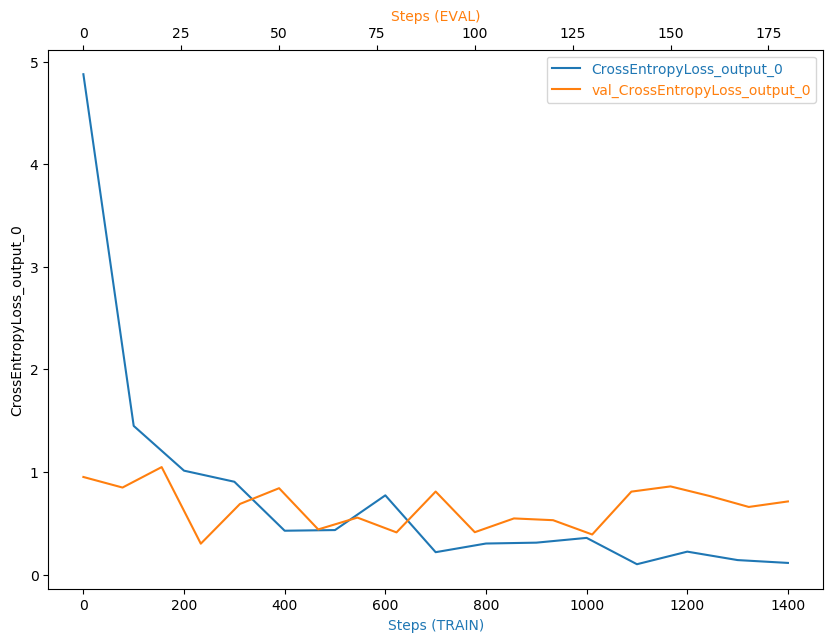

In [24]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [25]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [26]:
! aws s3 ls {rule_output_path} --recursive

2023-05-27 13:18:56     415383 Debugger-dogImages-pytorch-2023-05-27-12-55-17-107/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-05-27 13:18:56     270053 Debugger-dogImages-pytorch-2023-05-27-12-55-17-107/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-05-27 13:18:50        192 Debugger-dogImages-pytorch-2023-05-27-12-55-17-107/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-05-27 13:18:50      22490 Debugger-dogImages-pytorch-2023-05-27-12-55-17-107/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-05-27 13:18:50       1956 Debugger-dogImages-pytorch-2023-05-27-12-55-17-107/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-05-27 13:18:51        330 Debugger-dogImages-pytorch-2023-05-27-12-55-17-107/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-05-27 13:18:51       1593 Debugger-dogImages-pytorch-2023-05-

In [27]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-372206764755/Debugger-dogImages-pytorch-2023-05-27-12-55-17-107/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-372206764755/Debugger-dogImages-pytorch-2023-05-27-12-55-17-107/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-372206764755/Debugger-dogImages-pytorch-2023-05-27-12-55-17-107/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-372206764755/Debugger-dogImages-pytorch-2023-05-27-12-55-17-107/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json


In [28]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [29]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [3]:
model_data_path="s3://sagemaker-us-east-1-372206764755/Debugger-dogImages-pytorch-2023-05-27-12-55-17-107/output/model.tar.gz"
print(f"Model Data: {model_data_path}")

Model Data: s3://sagemaker-us-east-1-372206764755/Debugger-dogImages-pytorch-2023-05-27-12-55-17-107/output/model.tar.gz


In [6]:
import sagemaker
from sagemaker.predictor import Predictor

In [9]:
role=sagemaker.get_execution_role()

In [10]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [11]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=model_data_path, role=role, entry_point='endPoint.py', py_version='py36',
                             framework_version='1.6',
                             predictor_cls=ImagePredictor)
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

-----!

In [12]:
image_path = "./dogImages/test/006.American_eskimo_dog/American_eskimo_dog_00406.jpg"


In [20]:
with open (image_path , 'rb') as f :
    image = f.read()

In [14]:
# TODO: Run an prediction on the endpoint

# TODO: Your code to load and preprocess image to send to endpoint for prediction
response=predictor.predict(image, initial_args={"ContentType": "image/jpeg"})
response

[[-6.456831932067871,
  -11.895271301269531,
  -17.691547393798828,
  -10.051856994628906,
  -10.870057106018066,
  2.598403215408325,
  -19.42770767211914,
  -14.749955177307129,
  -16.419841766357422,
  -17.065427780151367,
  -12.96739673614502,
  -12.780563354492188,
  -9.362008094787598,
  -16.14512062072754,
  -17.62261962890625,
  -14.440216064453125,
  -15.328314781188965,
  -13.52930736541748,
  -7.954540729522705,
  -18.298465728759766,
  -8.849475860595703,
  -10.434394836425781,
  -18.23966407775879,
  -7.279758453369141,
  -16.896699905395508,
  -14.49659252166748,
  -13.5565185546875,
  -16.5316162109375,
  -14.927863121032715,
  -14.143494606018066,
  -12.675069808959961,
  -14.963257789611816,
  -11.202261924743652,
  -17.313182830810547,
  -20.026798248291016,
  -13.456900596618652,
  -12.526500701904297,
  -10.167147636413574,
  -14.985917091369629,
  -15.36017894744873,
  -16.924835205078125,
  -10.54306411743164,
  -10.272405624389648,
  -12.778155326843262,
  -10.82

In [15]:
import numpy as np 
np.argmax(response)+1

6

In [18]:
from PIL import Image
import io
import matplotlib.pyplot as plt

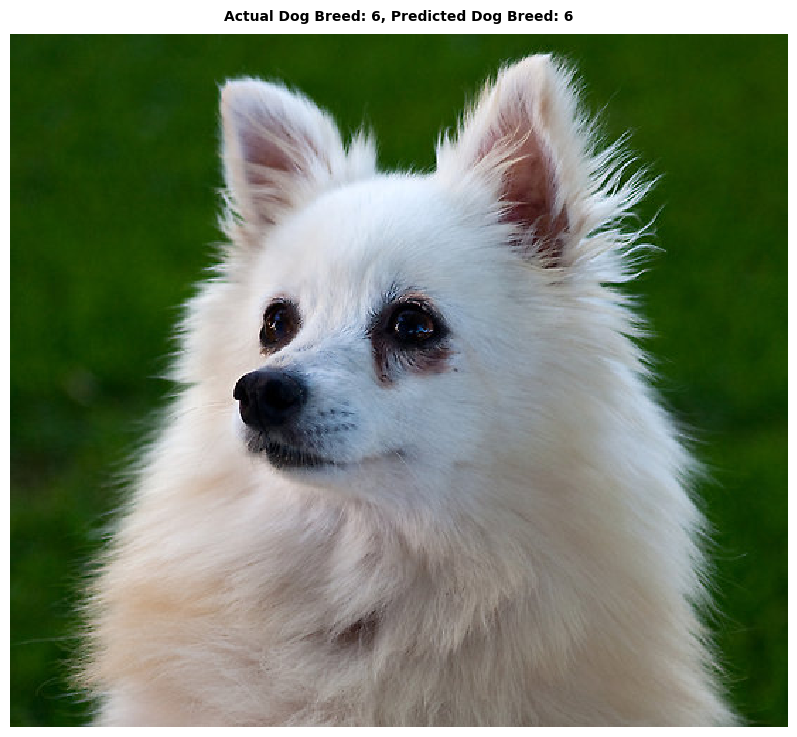

In [21]:
image=Image.open(io.BytesIO(image))
plt.figure(1, figsize=(15, 9))
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=10, titlepad=10)
plt.rc('image', cmap='magma')
actual_dog_breed=image_path.split("/")[3][2]
predicted_dog_breed=np.argmax(response)+1
plt.imshow(image,cmap='gray',vmin = -1.5, vmax = 1.5)
plt.axis('off')
plt.title(f"Actual Dog Breed: {actual_dog_breed}, Predicted Dog Breed: {predicted_dog_breed}")
plt.savefig("test_image.png")
plt.show();

In [47]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()